In [1]:
from astroquery.svo_fps import SvoFps
import numpy as np
from astropy.table import Table
from synphot import SourceSpectrum, Observation, units, SpectralElement
from synphot.models import Empirical1D
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from specutils import Spectrum1D
import matplotlib


In [2]:
# From: https://stackoverflow.com/questions/40581878/gradient-with-spectral-lines
def lin_inter(value, left=0., right=1., increase=True):
    if increase:
        return (value - left) / (right - left)
    else:
        return (right - value) / (right - left)
def wav2RGB(Wavelength, upto255=False, Gamma=1.0):
    if 380 <= Wavelength < 440:
        Red = lin_inter(Wavelength, 380., 440., False)
        Green = 0.0
        Blue = 1.0
    elif 440 <= Wavelength < 490:
        Red = 0.0
        Green = lin_inter(Wavelength, 440., 490., True)
        Blue = 1.0
    elif 490 <= Wavelength < 510:
        Red = 0.0
        Green = 1.0
        Blue = lin_inter(Wavelength, 490., 510., False)
    elif 510 <= Wavelength < 580:
        Red = lin_inter(Wavelength, 510., 580., True)
        Green = 1.0
        Blue = 0.0
    elif 580 <= Wavelength < 645:
        Red = 1.0
        Green = lin_inter(Wavelength, 580., 645., False)
        Blue = 0.0
    elif 645 <= Wavelength <= 780:
        Red = 1.0
        Green = 0.0
        Blue = 0.0
    else:
        Red = 0.0
        Green = 0.0
        Blue = 0.0
    if 380 <= Wavelength < 420:
        factor = 0.3 + 0.7*lin_inter(Wavelength, 380., 420., True)
    elif 420 <= Wavelength < 700:
        factor = 1.0
    elif 700 <= Wavelength <= 780:
        factor = 0.3 + 0.7*lin_inter(Wavelength, 700., 780., False)
    else:
        factor = 0.0
    if upto255:
        def Adjust(Color, Factor):
            return int(round(255. * (Color * Factor)**Gamma))
    else:
        def Adjust(Color, Factor):
            return (Color * Factor)**Gamma
    R = Adjust(Red, factor)
    G = Adjust(Green, factor)
    B = Adjust(Blue, factor)
    return [R, G, B]
    

In [3]:
# Get the list of OAJ/JPCam filters
JPAS_filter_list = SvoFps.get_filter_list(facility='OAJ', instrument='JPCam').to_pandas()
# Filters of interest (56 narrow - J0378)
JPAS_filter_ids = ('OAJ/JPAS.J0390', 'OAJ/JPAS.J0400',
                   'OAJ/JPAS.J0410', 'OAJ/JPAS.J0420', 'OAJ/JPAS.J0430', 'OAJ/JPAS.J0440', 'OAJ/JPAS.J0450',
                   'OAJ/JPAS.J0460', 'OAJ/JPAS.J0470', 'OAJ/JPAS.J0480', 'OAJ/JPAS.J0490',
                   'OAJ/JPAS.J0500', 'OAJ/JPAS.J0510', 'OAJ/JPAS.J0520', 'OAJ/JPAS.J0530', 'OAJ/JPAS.J0540',
                   'OAJ/JPAS.J0550', 'OAJ/JPAS.J0560', 'OAJ/JPAS.J0570', 'OAJ/JPAS.J0580', 'OAJ/JPAS.J0590',
                   'OAJ/JPAS.J0600', 'OAJ/JPAS.J0610', 'OAJ/JPAS.J0620', 'OAJ/JPAS.J0630',
                   'OAJ/JPAS.J0640', 'OAJ/JPAS.J0650', 'OAJ/JPAS.J0660', 'OAJ/JPAS.J0670', 'OAJ/JPAS.J0680',
                   'OAJ/JPAS.J0690', 'OAJ/JPAS.J0700', 'OAJ/JPAS.J0710', 'OAJ/JPAS.J0720', 'OAJ/JPAS.J0730',
                   'OAJ/JPAS.J0740', 'OAJ/JPAS.J0750', 'OAJ/JPAS.J0760', 'OAJ/JPAS.J0770',
                   'OAJ/JPAS.J0780', 'OAJ/JPAS.J0790', 'OAJ/JPAS.J0800', 'OAJ/JPAS.J0810', 'OAJ/JPAS.J0820',
                   'OAJ/JPAS.J0830', 'OAJ/JPAS.J0840', 'OAJ/JPAS.J0850', 'OAJ/JPAS.J0860', 'OAJ/JPAS.J0870',
                   'OAJ/JPAS.J0880', 'OAJ/JPAS.J0890', 'OAJ/JPAS.J0900', 'OAJ/JPAS.J0910')
# Filters transmission data
JPAS_waveRefAA = {} # WavelengthRef dict
JPAS_bp = {} # Bandpass dict
for filter_id in JPAS_filter_ids:
    JPAS_filter_tx = SvoFps.get_transmission_data(filter_id)
    JPAS_waveRefAA[filter_id] = JPAS_filter_list[JPAS_filter_list.filterID==filter_id].WavelengthRef.values[0]
    JPAS_bp[filter_id] = SpectralElement(Empirical1D, points=JPAS_filter_tx['Wavelength'], lookup_table=JPAS_filter_tx['Transmission'])


In [4]:
colors = [wav2RGB(point/10) for point in list(JPAS_waveRefAA.values())]
my_cmap = matplotlib.colors.ListedColormap(colors, name='my_colormap_name')


In [5]:
filename = 'spec-'+str(442).zfill(4)+'-'+str(51882)+'-'+str(494).zfill(4)+'.fits'
sp = Spectrum1D.read('cbdata_w_spec/'+filename)
JPAS_obs_effstim = {}
for k in JPAS_bp:
    obs = Observation(sp, JPAS_bp[k], force='taper')
    JPAS_obs_effstim[k[9:]] = obs.effstim('flam').value
dfEffstim = pd.DataFrame.from_dict([JPAS_obs_effstim])


In [7]:
def plotspec(plate, mjd, fiber, direc, title):
    filename = 'spec-'+str(plate).zfill(4)+'-'+str(mjd)+'-'+str(fiber).zfill(4)+'.fits'

    sp = Spectrum1D.read('cbdata_w_spec/'+filename)
    JPAS_obs_effstim = {}
    for k in JPAS_bp:
        obs = Observation(sp, JPAS_bp[k], force='taper')
        JPAS_obs_effstim[k[9:]] = obs.effstim('flam').value
    dfEffstim = pd.DataFrame.from_dict([JPAS_obs_effstim])

    hdul = fits.open(direc+filename)
    flux = hdul[1].data['flux']*1e-17*units.FLAM
    loglam = hdul[1].data['loglam']
    wave = 10 ** loglam
    sp = SourceSpectrum(Empirical1D, points=wave, lookup_table=flux, keep_neg=False)
    spu = units.convert_flux(sp.waveset, sp(sp.waveset), units.FLAM)
    t = np.arange(53)
    plt.figure(figsize=(16,4))
    plt.plot(sp.waveset.value, spu.value, c="gray")
    plt.scatter(JPAS_waveRefAA.values(), dfEffstim.values[0], c=t, cmap=my_cmap)
    plt.xlabel('Wavelength [Ångströms]')
    plt.ylabel('Flux [erg/cm²/s/Å]')
    plt.title(title+' ; '+hdul[2].data['CLASS'][0]+' '+hdul[2].data['SUBCLASS'][0])
    plt.show()


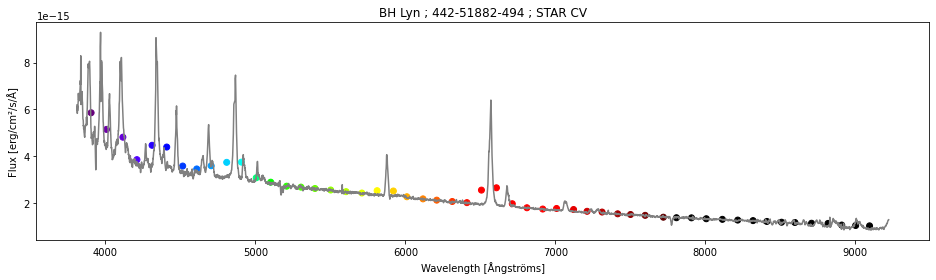

In [8]:
plotspec(442, 51882, 494, './cbdata_w_spec/', 'BH Lyn ; 442-51882-494')
